# Exploring Autoencoders Applied to Neural Recordings

In [1]:
import os
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import Input, Model, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv1DTranspose, Dropout
from keras.utils import to_categorical
from knn import test_knn
from utils import get_dataset, standardize, normalize, plotting

SIZES = []
RED_DIM = 3

In [2]:
### data setup

dataset = get_dataset()

In [3]:
### extraction and preprocessing

X_df = dataset.drop(['cellType','subj'],axis=1)
G_df = dataset['cellType']
features = X_df.columns.values

X = normalize(standardize(X_df.values))
G = G_df.values

y = np.zeros(len(G))
cells = np.unique(G)
for i, cell in enumerate(cells):
    y[G==cell] = i

y = y.astype(int)
y_cat = to_categorical(y,3)

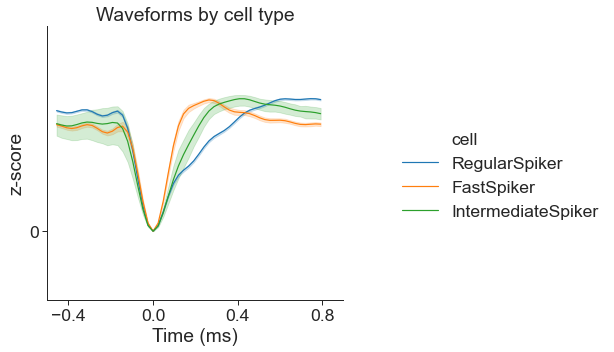

In [4]:
### visualize normalized waveforms by cell type

plotting.plot_by_cell_types(X,G,features,'Waveforms by cell type','norm_waveforms')

Note that in this notebook the recordings are normalized between 0 and 1. *For summary stats and preliminary waveform visualizations, see the neural_PCA notebook.* 

## Autoencoder

In [5]:
### autoencoder builder function

def create_ae(init='uniform',activation='relu',optimizer='adam',ret_comp=False):
    """
    sizes: list of layer sizes in decreasing order until encoding --> mirrored for decoding
    ret_all: returns components of the autoencoder as well if True
    """
    global SIZES
    
    if len(SIZES) < 2: 
        raise ValueError("Autoencoder must have at least 3 layers.")
        
    autoencoder = Sequential(name='autoencoder')
    encoder = Sequential(name='encoder')
    decoder = Sequential(name='decoder')
    
    # encoder
    autoencoder.add(Input(shape=(SIZES[0],)))
    print(autoencoder.layers)
    for size in SIZES[1:]:
        autoencoder.add(Dense(size,kernel_initializer=init,activation=activation))
        encoder.add(autoencoder.layers[-1])
    
    encoder.build(input_shape=(None,SIZES[0]))
    
    # decoder
    for size in reversed(SIZES[1:-1]):
        autoencoder.add(Dense(size,kernel_initializer=init,activation=activation))
        decoder.add(autoencoder.layers[-1])
        
    autoencoder.add(Dense(SIZES[0],kernel_initializer=init,activation='sigmoid'))
    decoder.add(autoencoder.layers[-1])
    
    decoder.build(input_shape=(None,SIZES[-1]))
     
    autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return [autoencoder, encoder, decoder] if ret_comp else autoencoder

*See grid search implementation stored in the utils directory.*

While initially attempting a grid search to find the best model, debugging was truly a trial in patience. Scikit has an underlying [bug in its GridSearchCV function](https://github.com/keras-team/keras/issues/13586) that may throw an error on any hyperparameter that modifies the architecture of the network. Here, this bug popped up a few times for layer tuning. So in order to tune the layers and sizes a global parameter needs to be set prior to grid searching. Overall, scikit's grid search in tandem with the Keras wrapper is very buggy; another bug reared when I tried to tune the loss function with cosine similarity. On a lighter note, normalizing the recordings to [0,1] enormously impacted the model, resulting in consistently better final accuracy scores. As many guides note, the grid search implementation has underlying randomization so running multiple times and averaging might be a good idea; however, I've found that once a good set of params is available then the search will usually hover around those consistently upon repeat. 

Also, from the [Keras AE example](https://blog.keras.io/building-autoencoders-in-keras.html), I noticed that the accuracy of the AE is not indicative of performance. However, the loss is a good indicator of how similar the decoded images are to the original images. Unfortunately, KerasClassifier is incompatible with any built-in scoring metrics from scikit, with both the functional and sequential Keras APIs. For this problem, an appropriate scoring metric would probably be the resulting accuracy from a KNN applied to the latent space encodings. 

Unsurprisingly at this point, another problem arose with grid search: the autoencoder generates the same output waveform regardless of input with the "best" hyperparameters. I believe that this phenomenon is considered *mode collapse*. I'm currently investigating mode collapse with GANs in my lab research so, at this point, I'll admit I became deterred and abandoned grid search in lieu of manually searching for a simple, fast shallow autoencoder that ideally will learn PCA. 

In [6]:
### fit model with selected params

RED_DIM = 3
SIZES = [X.shape[1],RED_DIM]
ae, encoder, decoder = create_ae('uniform','tanh','adam',ret_comp=True)

### train the autoencoder

history = ae.fit(X, X,
                epochs=40,
                batch_size=1,
                shuffle=True,
                validation_split=0.1)

[]
Epoch 1/40
271/271 [==============================] - 0s 959us/step - loss: 0.5722 - accuracy: 0.0554 - val_loss: 0.4870 - val_accuracy: 0.0323
Epoch 2/40
271/271 [==============================] - 0s 600us/step - loss: 0.4643 - accuracy: 0.0775 - val_loss: 0.4378 - val_accuracy: 0.0323
Epoch 3/40
271/271 [==============================] - 0s 580us/step - loss: 0.4388 - accuracy: 0.0627 - val_loss: 0.4237 - val_accuracy: 0.0323
Epoch 4/40
271/271 [==============================] - 0s 616us/step - loss: 0.4314 - accuracy: 0.0775 - val_loss: 0.4190 - val_accuracy: 0.2258
Epoch 5/40
271/271 [==============================] - 0s 738us/step - loss: 0.4289 - accuracy: 0.1587 - val_loss: 0.4174 - val_accuracy: 0.0323
Epoch 6/40
271/271 [==============================] - 0s 720us/step - loss: 0.4278 - accuracy: 0.1587 - val_loss: 0.4165 - val_accuracy: 0.0323
Epoch 7/40
271/271 [==============================] - 0s 665us/step - loss: 0.4273 - accuracy: 0.1587 - val_loss: 0.4163 - val_accura

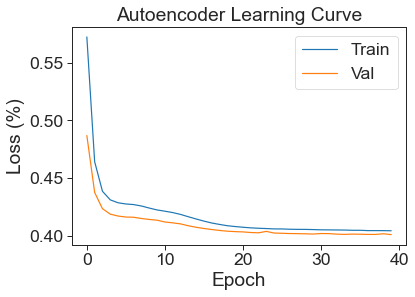

In [7]:
### learning curve

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Learning Curve')
plt.ylabel('Loss (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
fig = plt.gcf()
fig.savefig('imgs/ae_learning_curve.png')

Another helpful reference for autoencoders on time series in particular is [this Medium post](https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e). The loss curves for the training show that loss doesn't converge to 0, which I didn't notice at first and as mentioned above I spent a substantial amount of time debugging a grid search to find the *perfect* model based on loss and accuracy. Nonetheless, the curve shows that the loss converges to some value and **I need to investigate whether / how this relates to the explained variance**. 

[This post](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) provides some insight into interpreting the learning curve. Although the author's context for the interpretation isn't in deep learning, I still think it makes sense. The model is probably underfitting the training set since I haven't found just the right hyperparameters and the validation set is probably unrepresentative due to unbalanced classes. 

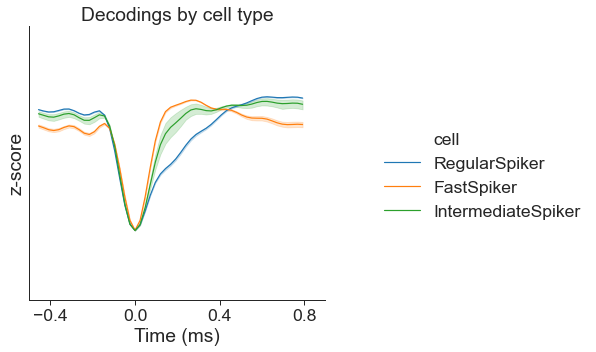

In [8]:
### encode and visualize the decoded images

encodings = encoder.predict(X)
decodings = decoder.predict(encodings)

plotting.plot_by_cell_types(decodings,G,features,'Decodings by cell type','waveform_decodings')

In [9]:
dim_red_cells = pd.DataFrame(np.hstack([encodings,y.reshape(-1,1)]),columns=['Comp1','Comp2','Comp3','y'])
dim_red_cells.describe()

,Comp1,Comp2,Comp3,y
count,302.000000,302.000000,302.000000,302.000000
mean,0.759493,-0.668363,-0.451748,1.655629
std,0.178377,0.232660,0.584896,0.743042
min,-0.322899,-0.982215,-0.993353,0.000000
25%,0.753595,-0.828925,-0.814317,2.000000
50%,0.818935,-0.671330,-0.724844,2.000000
75%,0.855102,-0.535250,-0.412042,2.000000
max,0.933625,0.676807,0.922899,2.000000


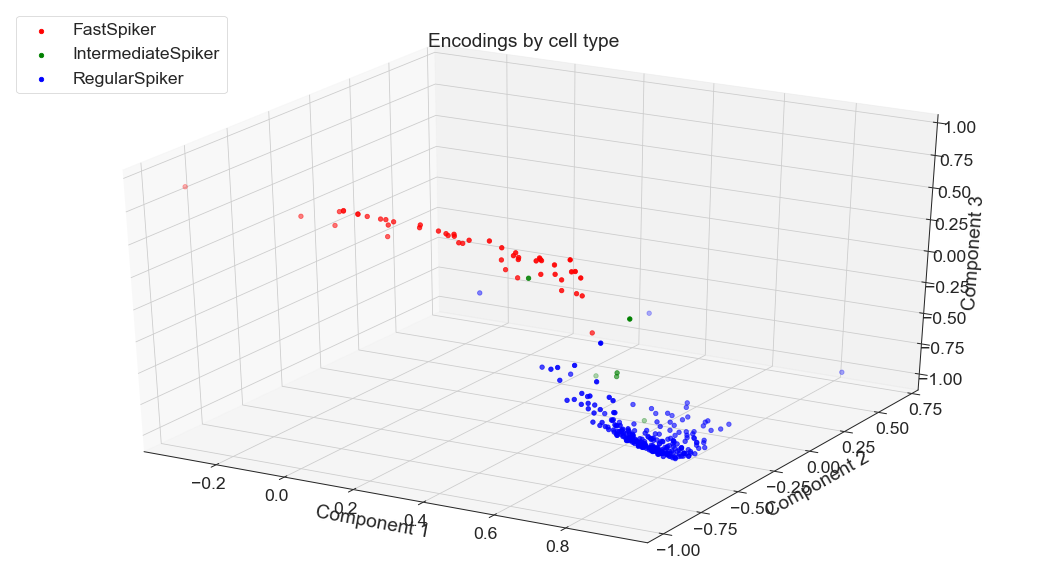

In [10]:
### visualizing the encodings

plotting.plot_3d(dim_red_cells,cells,"Encodings by cell type","encoded_cells")

Originally, the decoded waveforms look empirically similar to the original waveforms. However, they appear to be condensing closer to a single waveform which suggests that the autoencoder is heading for mode collapse. Moreover, two of the components had zeroed out but when I removed dropout layers from the AE the decodings became more variant and closer to the original waveforms and only one of the components had zeroed out. 

I actually tried fitting a model with only two 2 encoded components but it collapsed the model and the waveforms were all identical. Plus, I couldn't make a cool 3D visualization without 3 components (even if one is zeroed out). 

Intuitively, a zeroed out component sounds harrowing when it comes to describing a functioning autoencoder and separable classes. Fortunately, the 3D visualization demonstrates that the classes are in fact separated and at first glance look more sequestered to their own spaces than those with PCA. Different architectures resulted in different compressions: 
- A shallow architecture resulted in a 2D crescent-shaped hyperplane. 
- Adding more layers compressed the encodings into a linear hyperplane. 
- Changing from ReLU to tanh activation created a spoon-shaped hyperplane. 
- Changing from Adam to SGD optimization compresed the space into parallel lines for each class. 
- Changing from uniform to normal initialization resulted another distinctly crescent-shaped hyperplane.
    - Due to the randomness of initialization, it resulted in very different hyperplanes for the projections.

Conclusively, AEs are very sensitive to their hyperparameters, which can make or break dimensionality reduction. Although simple, some combos of hyperparameters result in a projection onto a linear hyperplane, which for some classification problems may obfuscate some of the variance needed to distinguish classes. Ultimately, the parameters that I decided to go with are those used in the above model. 

In [11]:
### testing on the encodings

print("Unstratified:\n")
test_knn(encodings,y,cells,123)
test_knn(encodings,y,cells,42)
test_knn(encodings,y,cells,66)

Unstratified:

Seed = 123
Chosen k:  1
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 'FastSpiker', 'IntermediateSpiker'), (13, 'RegularSpiker', 'IntermediateSpiker'), (24, 'FastSpiker', 'RegularSpiker')]
Debug accuracy:  1.0
Misclassified indices in the form (index, prediction, truth):  []
Time taken:  2.139664888381958

Seed = 42
Chosen k:  7
Final accuracy:  0.967741935483871
Misclassified indices:  [(10, 'IntermediateSpiker', 'FastSpiker')]
Debug accuracy:  0.974169741697417
Misclassified indices in the form (index, prediction, truth):  [(5, 'RegularSpiker', 'IntermediateSpiker'), (31, 'IntermediateSpiker', 'RegularSpiker'), (41, 'RegularSpiker', 'IntermediateSpiker'), (59, 'FastSpiker', 'IntermediateSpiker'), (104, 'FastSpiker', 'IntermediateSpiker'), (204, 'RegularSpiker', 'IntermediateSpiker'), (260, 'RegularSpiker', 'IntermediateSpiker')]
Time taken:  3.456328868865967

Seed = 66
Chosen k:  1
Final accuracy:  0.967741935483871
Misclassified indices:  [(25, 'I

In [12]:
print("Stratified:\n")
test_knn(encodings,y,cells,123,stratify=True,n_splits=4)
test_knn(encodings,y,cells,42,stratify=True,n_splits=4)
test_knn(encodings,y,cells,66,stratify=True,n_splits=4)

Stratified:

Seed = 123
Chosen k:  1
Final accuracy:  0.9032258064516129
Misclassified indices:  [(12, 'FastSpiker', 'IntermediateSpiker'), (13, 'RegularSpiker', 'IntermediateSpiker'), (24, 'FastSpiker', 'RegularSpiker')]
Debug accuracy:  1.0
Misclassified indices in the form (index, prediction, truth):  []
Time taken:  2.1018481254577637

Seed = 42
Chosen k:  1
Final accuracy:  0.967741935483871
Misclassified indices:  [(10, 'RegularSpiker', 'FastSpiker')]
Debug accuracy:  1.0
Misclassified indices in the form (index, prediction, truth):  []
Time taken:  2.2050371170043945

Seed = 66
Chosen k:  1
Final accuracy:  0.967741935483871
Misclassified indices:  [(25, 'IntermediateSpiker', 'FastSpiker')]
Debug accuracy:  1.0
Misclassified indices in the form (index, prediction, truth):  []
Time taken:  2.0325660705566406



For AE compression, the results are on par with those from PCA, at least for a KNN -- a future direction could be to compare with other classification models to confirm if this still holds true. The unbalanced dataset expectedly causes misclassifications when it comes to intermediate spikers. It looks like stratified splits yield better results for the encodings than for the principal components but don't quote me because I haven't run these tests 100 times to declare a P-value. Overall, autoencoders appear to be just as good as PCA even with a very shallow architecture!